<a href="https://colab.research.google.com/github/Darshil999/DSC_Project/blob/main/DscProject_76_82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, r2_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving salary.csv to salary.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['salary.csv']))
print(df)

       age     workclass  fnlwgt     education  educational-num  \
0       25       Private  226802          11th                7   
1       38       Private   89814       HS-grad                9   
2       28     Local-gov  336951    Assoc-acdm               12   
3       44       Private  160323  Some-college               10   
4       18             ?  103497  Some-college               10   
...    ...           ...     ...           ...              ...   
48837   27       Private  257302    Assoc-acdm               12   
48838   40       Private  154374       HS-grad                9   
48839   58       Private  151910       HS-grad                9   
48840   22       Private  201490       HS-grad                9   
48841   52  Self-emp-inc  287927       HS-grad                9   

           marital-status         occupation relationship   race  gender  \
0           Never-married  Machine-op-inspct    Own-child  Black    Male   
1      Married-civ-spouse    Farming-fishin

# **1. EDA AND DATA CLEANING**





In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [ ]:
df.describe()


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
df.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [ ]:
df.nunique()

age                   74
workclass              9
fnlwgt             28523
education             16
educational-num       16
marital-status         7
occupation            15
relationship           6
race                   5
gender                 2
capital-gain         123
capital-loss          99
hours-per-week        96
native-country        42
income                 2
dtype: int64

In [ ]:
def convert_marital_status(status):
    if status in ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']:
        return 'married'
    elif status in ['Never-married', 'Separated', 'Widowed']:
        return 'single'
    else:
        return 'divorced'

df['marital-status'] = df['marital-status'].apply(convert_marital_status)

df['native-country'] = df['native-country'].replace('Outlying-US(Guam-USVI-etc)' , 'US Minor Islands')

df = df.drop(['capital-gain', 'capital-loss', 'fnlwgt'], axis=1)

income_mapping = {'<=50K': 0, '>50K': 1}
df['income'] = df['income'].map(income_mapping)

# **2.Data Preprocessing**

In [ ]:
def fill_missing_categorical(df, column):
    df[column] = df[column].replace('?', np.nan)

    if df[column].notna().all():
        return df

    known = df[df[column].notna()]
    unknown = df[df[column].isna()]

    le = LabelEncoder()
    known[column] = le.fit_transform(known[column])
    X_known = known.drop(column, axis=1)
    y_known = known[column]

    categorical_cols = X_known.select_dtypes(include=['object']).columns

    le_cat = preprocessing.LabelEncoder()
    X_known[categorical_cols] = X_known[categorical_cols].apply(lambda col: le_cat.fit_transform(col.astype(str)))

    clf = RandomForestClassifier()
    clf.fit(X_known, y_known)

    X_unknown = unknown.drop(column, axis=1)

    X_unknown[categorical_cols] = X_unknown[categorical_cols].apply(lambda col: le_cat.fit_transform(col.astype(str)))

    unknown[column] = clf.predict(X_unknown)

    df = pd.concat([known, unknown], axis=0)

    df[column] = le.inverse_transform(df[column])

    return df

In [ ]:
df = fill_missing_categorical(df, 'native-country')
df = fill_missing_categorical(df, 'occupation')
df = fill_missing_categorical(df, 'workclass')

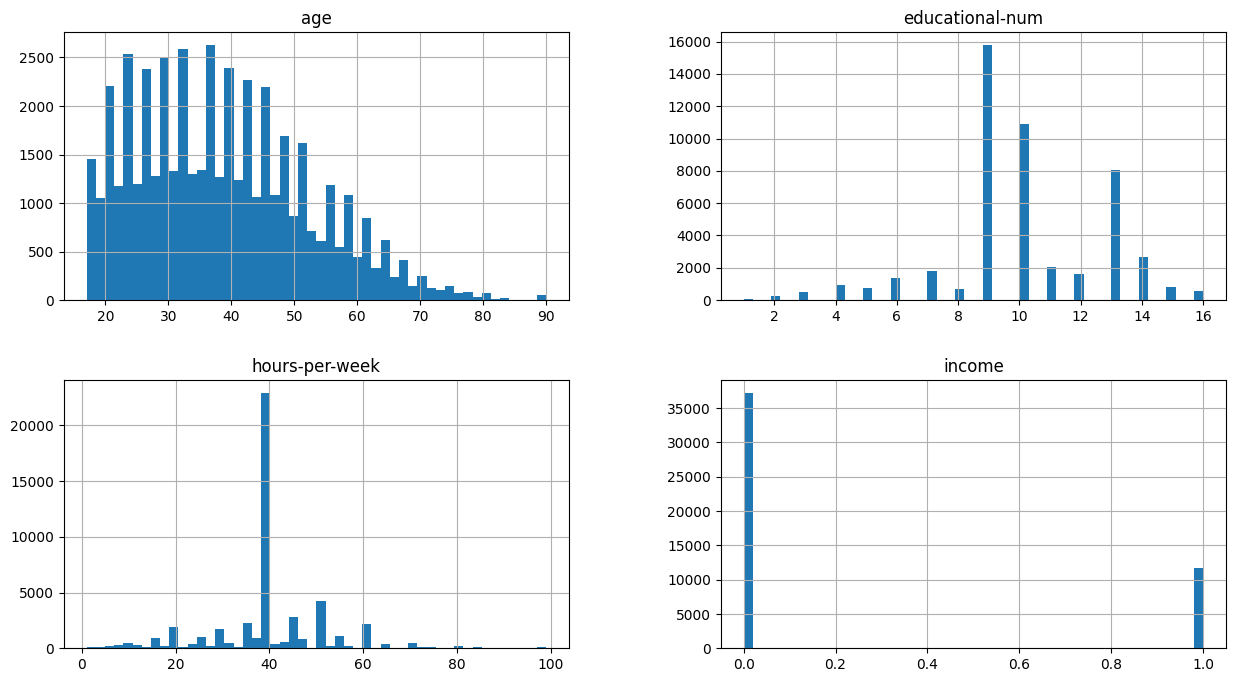

In [ ]:
df.hist(figsize=(15, 8),bins = 50)
plt.show()

<Figure size 500x200 with 0 Axes>

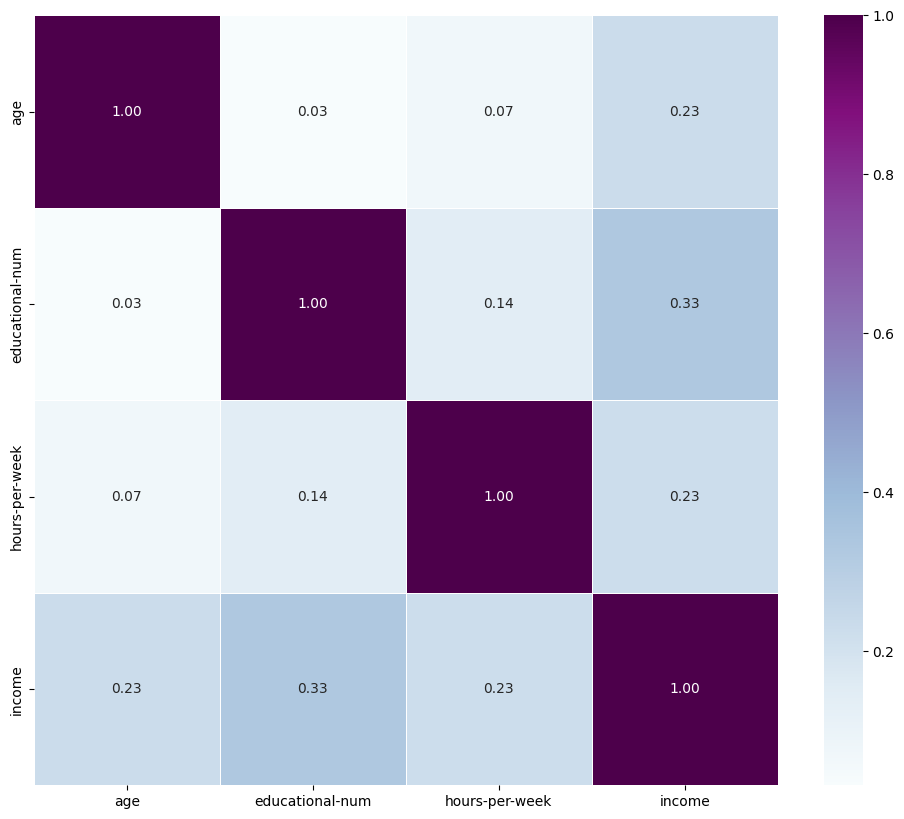

In [ ]:
plt.figure(figsize=(5, 2))
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt=".2f", linewidths=.5)
plt.show()

**The best features for our Model is (workclass, educational-num, marital-status, occupation, gender, hours-per-week)**

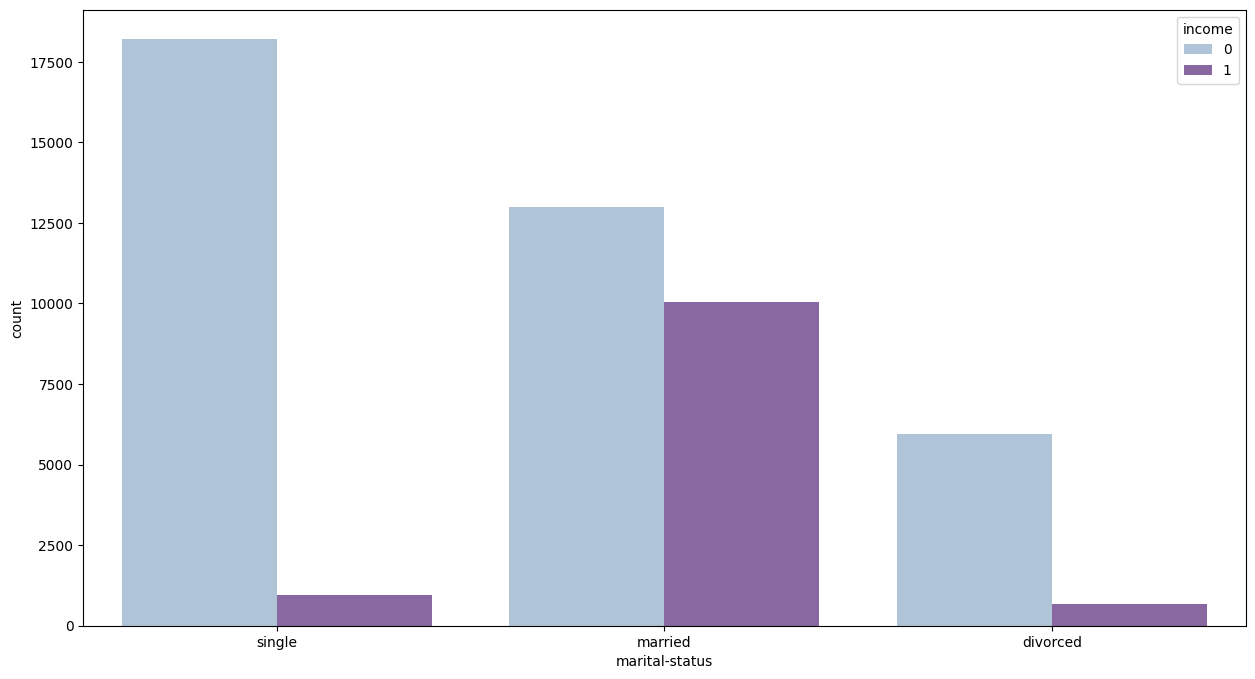

In [ ]:
plt.figure(figsize=(15, 8))
sns.countplot(data=df, x='marital-status', hue='income', palette="BuPu")
plt.show()

# **3.Feature Scaling & Handling Outliers**

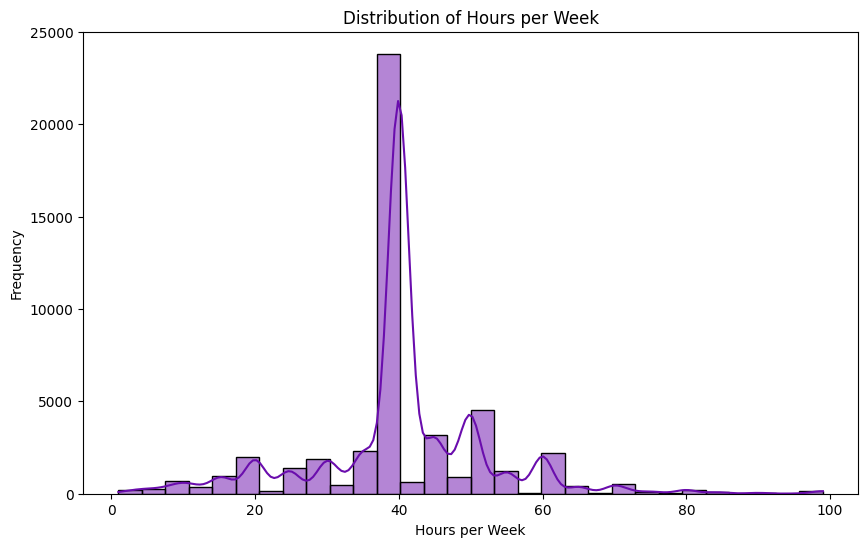

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['hours-per-week'], kde=True, bins=30, color='#6A0DAD')
plt.title('Distribution of Hours per Week')
plt.xlabel('Hours per Week')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48842 entries, 0 to 48806
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   education        48842 non-null  object
 3   educational-num  48842 non-null  int64 
 4   marital-status   48842 non-null  object
 5   occupation       48842 non-null  object
 6   relationship     48842 non-null  object
 7   race             48842 non-null  object
 8   gender           48842 non-null  object
 9   hours-per-week   48842 non-null  int64 
 10  native-country   48842 non-null  object
 11  income           48842 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 4.8+ MB


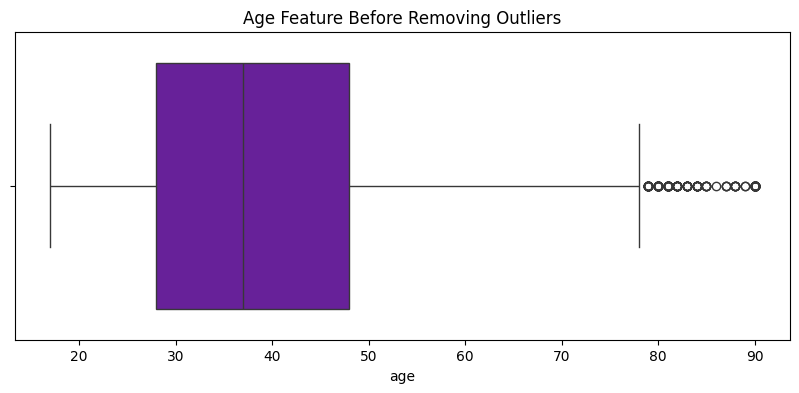

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['age'], color = '#6A0DAD')
plt.title('Age Feature Before Removing Outliers')
plt.show()

In [ ]:
#Remove the Outliers
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['age'] < Q1 - 1.5 * IQR) | (df['age'] > Q3 + 1.5 * IQR)]

df.drop(outliers.index, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48626 entries, 0 to 46650
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48626 non-null  int64 
 1   workclass        48626 non-null  object
 2   education        48626 non-null  object
 3   educational-num  48626 non-null  int64 
 4   marital-status   48626 non-null  object
 5   occupation       48626 non-null  object
 6   relationship     48626 non-null  object
 7   race             48626 non-null  object
 8   gender           48626 non-null  object
 9   hours-per-week   48626 non-null  int64 
 10  native-country   48626 non-null  object
 11  income           48626 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 4.8+ MB


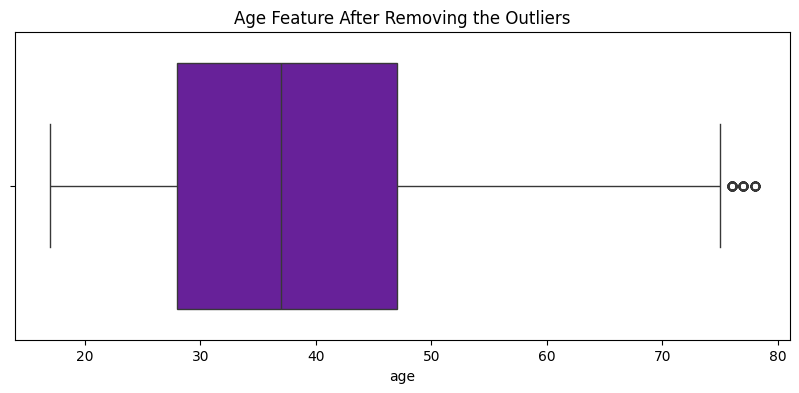

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['age'],color = '#6A0DAD')
plt.title('Age Feature After Removing the Outliers')
plt.show()

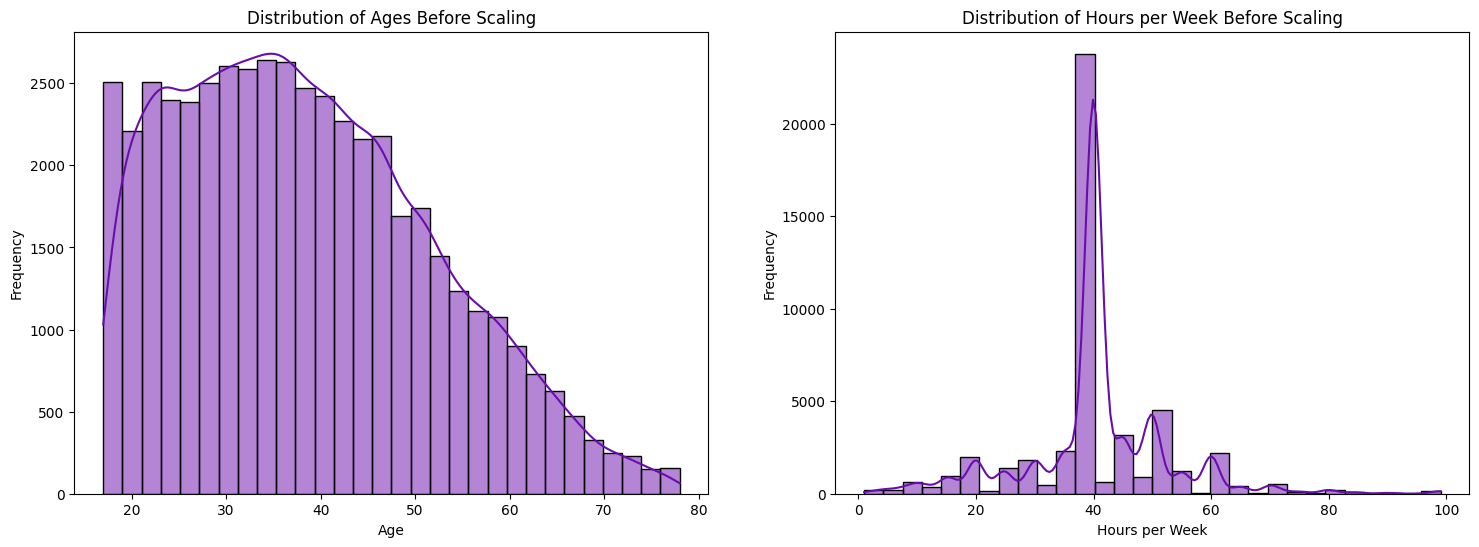

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Distribution plot for 'age'
sns.histplot(df['age'], kde=True, bins=30, color = '#6A0DAD', ax=axes[0])
axes[0].set_title('Distribution of Ages Before Scaling')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Distribution plot for 'hours-per-week'
sns.histplot(df['hours-per-week'], kde=True, bins=30, color = '#6A0DAD', ax=axes[1])
axes[1].set_title('Distribution of Hours per Week Before Scaling')
axes[1].set_xlabel('Hours per Week')
axes[1].set_ylabel('Frequency')

plt.show()

In [ ]:
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [ ]:
df.drop(['age', 'hours-per-week'], axis=1, inplace=True)
df

,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,native-country,income
0,Private,11th,7,single,Machine-op-inspct,Own-child,Black,1,United-States,0
1,Private,HS-grad,9,married,Farming-fishing,Husband,White,1,United-States,0
2,Local-gov,Assoc-acdm,12,married,Protective-serv,Husband,White,1,United-States,1
3,Private,Some-college,10,married,Machine-op-inspct,Husband,Black,1,United-States,1
5,Private,10th,6,single,Other-service,Not-in-family,White,1,United-States,0
...,...,...,...,...,...,...,...,...,...,...
42577,Self-emp-not-inc,7th-8th,4,single,Other-service,Not-in-family,White,0,United-States,0
42644,Private,Some-college,10,married,Craft-repair,Husband,White,1,United-States,1
44475,Private,Bachelors,13,married,Prof-specialty,Not-in-family,White,1,United-States,0
44969,Private,Some-college,10,single,Adm-clerical,Own-child,White,0,United-States,0


In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.columns

Index(['index', 'workclass', 'education', 'educational-num', 'marital-status',
       'occupation', 'relationship', 'race', 'gender', 'native-country',
       'income'],
      dtype='object')

# **Now  lets do analysis **

Hours per week

In [ ]:
max = df['hours-per-week'].max()
min = df['hours-per-week'].min()
mean = df['hours-per-week'].mean()
median = df['hours-per-week'].median()
std_dev = df['hours-per-week'].std()
var = df['hours-per-week'].var()
skew = df['hours-per-week'].skew()
kurt = df['hours-per-week'].kurt()
print(f'max: {max}')
print(f'min: {min}')
print(f"mean: {mean}")
print(f'median: {median}')
print(f'standard deviation: {std_dev}')
print(f'variance: {var}')
print(f'skewness: {skew}')
print(f'kurtosis: {kurt}')

max: 99
min: 1
mean: 40.422382375824085
median: 40.0
standard deviation: 12.391444024252307
variance: 153.5478850061782
skewness: 0.23874965720275756
kurtosis: 2.9510590898442954


In [ ]:
df[(df['hours-per-week'] == 10.0)]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K
86,20,Federal-gov,244689,11th,7,Never-married,Other-service,Own-child,White,Female,0,0,10,United-States,<=50K
89,41,?,38434,Masters,14,Married-civ-spouse,?,Wife,White,Female,7688,0,10,United-States,>50K
92,33,Private,176410,Masters,14,Married-civ-spouse,Prof-specialty,Wife,White,Female,5178,0,10,United-States,>50K
378,73,?,73402,Some-college,10,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48396,29,Private,119359,HS-grad,9,Married-civ-spouse,Prof-specialty,Wife,Asian-Pac-Islander,Female,0,0,10,China,>50K
48434,65,Private,174603,5th-6th,3,Widowed,Machine-op-inspct,Not-in-family,White,Female,0,0,10,Italy,<=50K
48525,58,Self-emp-not-inc,99141,HS-grad,9,Divorced,Farming-fishing,Unmarried,White,Female,0,0,10,United-States,<=50K
48565,26,Private,164488,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,10,United-States,<=50K


now lets check for atleast more than 50 hours per week

In [ ]:
hours_50 = df[(df['hours-per-week'] > 50)]
hours_50[(hours_50['hours-per-week'] == (hours_50['hours-per-week'].max()))]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
384,29,Private,211208,11th,7,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,99,United-States,>50K
901,37,Private,112158,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,7688,0,99,United-States,>50K
1121,31,Local-gov,378426,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,99,Columbia,<=50K
1156,48,?,117054,5th-6th,3,Divorced,?,Not-in-family,White,Male,0,0,99,United-States,<=50K
1649,52,Private,254680,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,0,99,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47273,40,Self-emp-inc,104235,Masters,14,Never-married,Other-service,Own-child,White,Male,0,0,99,United-States,<=50K
47962,43,Private,266324,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1902,99,United-States,>50K
47980,43,Self-emp-not-inc,163108,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,99,United-States,<=50K
48750,58,Self-emp-inc,181974,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,99,?,<=50K


In [ ]:
max_hours = int(df["hours-per-week"].max())
data_frame = pd.DataFrame({
    "mean":[mean for i in range(max_hours)],
    "median":[median for i in range(max_hours)],
    "std_dev":[std_dev for i in range(max_hours)],
    "variance":[var for i in range(max_hours)],
    "skewness":[skew for i in range(max_hours)],
    "kurtosis":[kurt for i in range(max_hours)]
})

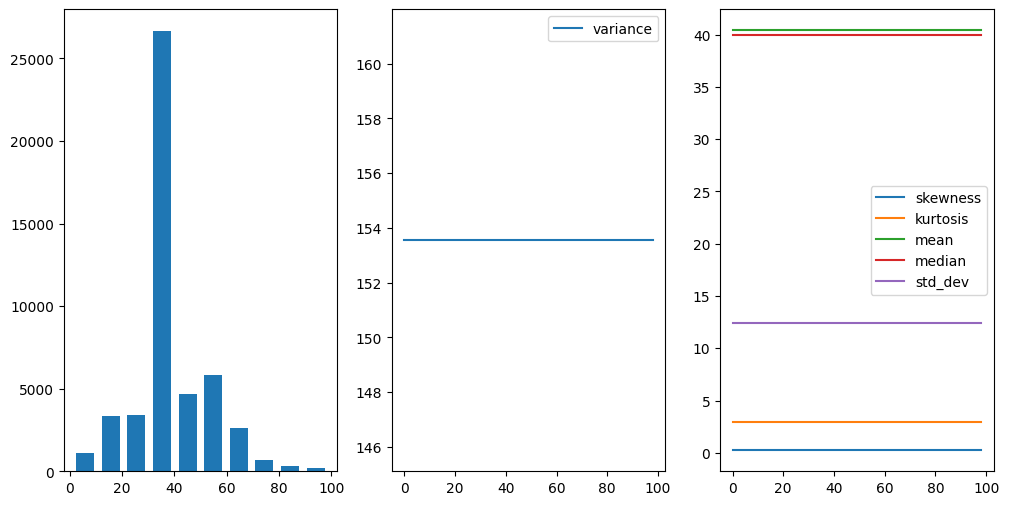

In [ ]:
plt.figure(figsize = (12,6))
plt.subplot(1,3,1)
plt.hist(df["hours-per-week"], rwidth = 0.7)

plt.subplot(1,3,2)
data_frame["variance"].plot()
plt.legend(["variance"])

plt.subplot(1,3,3)
data_frame["skewness"].plot()
data_frame["kurtosis"].plot()
data_frame["mean"].plot()
data_frame["median"].plot()
data_frame["std_dev"].plot()
plt.legend(["skewness", "kurtosis", "mean", "median", "std_dev"])
plt.show()

In [ ]:
chunks = [df[i:i+1000] for i in range(0, len(df), 150)]
skewness = [chunk['hours-per-week'].skew() for chunk in chunks]
kurtosis = [chunk['hours-per-week'].kurtosis() for chunk in chunks]
print(skewness)
print(kurtosis)

[0.3157762078143039, 0.41616754653831645, 0.4511935366229641, 0.20422900273554923, 0.22861468633542414, 0.2869870474906526, 0.2870139677067195, 0.2291225061453752, 0.11875178837167465, 0.16690360461334378, 0.2947465926222063, 0.22214677356018625, 0.1761629335589581, 0.16915371493866016, 0.16862781287791076, 0.30592429676585253, 0.2964941329855541, 0.34759428713239965, 0.4160823346530676, 0.41392958875800373, 0.4316242336009859, 0.3935309308087038, 0.27376907635685427, 0.14402453955279182, 0.10808893421755993, -0.0792544376468366, -0.03045387393204721, -0.2370593873626593, -0.06742946198491732, -0.012773200479013704, 0.17387384467651, 0.29402940605978495, 0.2664145526993477, 0.493208029784835, 0.528798240503669, 0.5285479658484025, 0.6128781155465077, 0.491301690381811, 0.33191575015132807, 0.26752725817193174, 0.25109219225201707, 0.06196760421820968, 0.1563508888987604, 0.21830611611621475, 0.3382896904005649, 0.2914681252911309, 0.25772504858047746, 0.40984965883914154, 0.39408089842

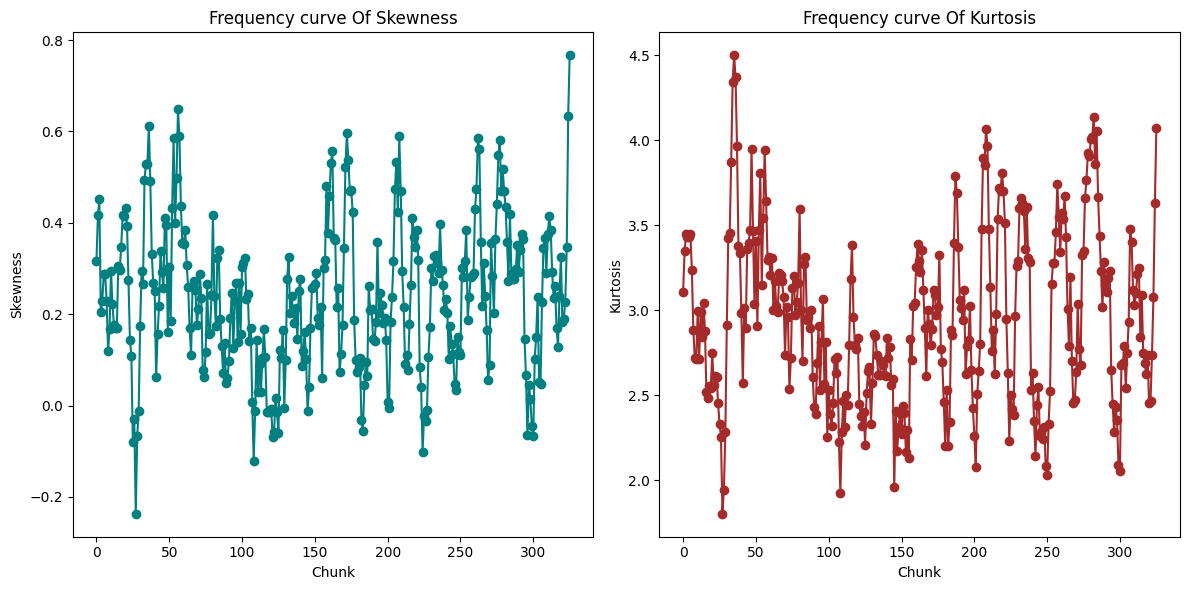

In [ ]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(np.arange(len(skewness)), skewness, color='teal', marker='o', linestyle='-')
plt.title('Frequency curve Of Skewness')
plt.xlabel('Chunk')
plt.ylabel('Skewness')

plt.subplot(1,2,2)
plt.plot(np.arange(len(kurtosis)), kurtosis, color='brown', marker='o', linestyle='-')
plt.title('Frequency curve Of Kurtosis')
plt.xlabel('Chunk')
plt.ylabel('Kurtosis')

plt.tight_layout()
plt.show()

In [ ]:
max = df['hours-per-week'].max()
min = df['hours-per-week'].min()
mean = df['hours-per-week'].mean()
median = df['hours-per-week'].median()
std_dev = df['hours-per-week'].std()
var = df['hours-per-week'].var()
skew = df['hours-per-week'].skew()
kurt = df['hours-per-week'].kurt()
print(f'max: {max}')
print(f'min: {min}')
print(f"mean: {mean}")
print(f'median: {median}')
print(f'standard deviation: {std_dev}')
print(f'variance: {var}')
print(f'skewness: {skew}')
print(f'kurtosis: {kurt}')

max: 99
min: 1
mean: 40.422382375824085
median: 40.0
standard deviation: 12.391444024252307
variance: 153.5478850061782
skewness: 0.23874965720275756
kurtosis: 2.9510590898442954


In [ ]:
df[(df['hours-per-week'] == 99)]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
384,29,Private,211208,11th,7,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,99,United-States,>50K
901,37,Private,112158,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,7688,0,99,United-States,>50K
1121,31,Local-gov,378426,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,99,Columbia,<=50K
1156,48,?,117054,5th-6th,3,Divorced,?,Not-in-family,White,Male,0,0,99,United-States,<=50K
1649,52,Private,254680,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,0,99,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47273,40,Self-emp-inc,104235,Masters,14,Never-married,Other-service,Own-child,White,Male,0,0,99,United-States,<=50K
47962,43,Private,266324,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1902,99,United-States,>50K
47980,43,Self-emp-not-inc,163108,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,99,United-States,<=50K
48750,58,Self-emp-inc,181974,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,99,?,<=50K


In [ ]:
max_hour = int(df["hours-per-week"].max())
data_frame = pd.DataFrame({
    "mean":[mean for i in range(max_hour)],
    "median":[median for i in range(max_hour)],
    "std_dev":[std_dev for i in range(max_hour)],
    "variance":[var for i in range(max_hour)],
    "skewness":[skew for i in range(max_hour)],
    "kurtosis":[kurt for i in range(max_hour)]
})

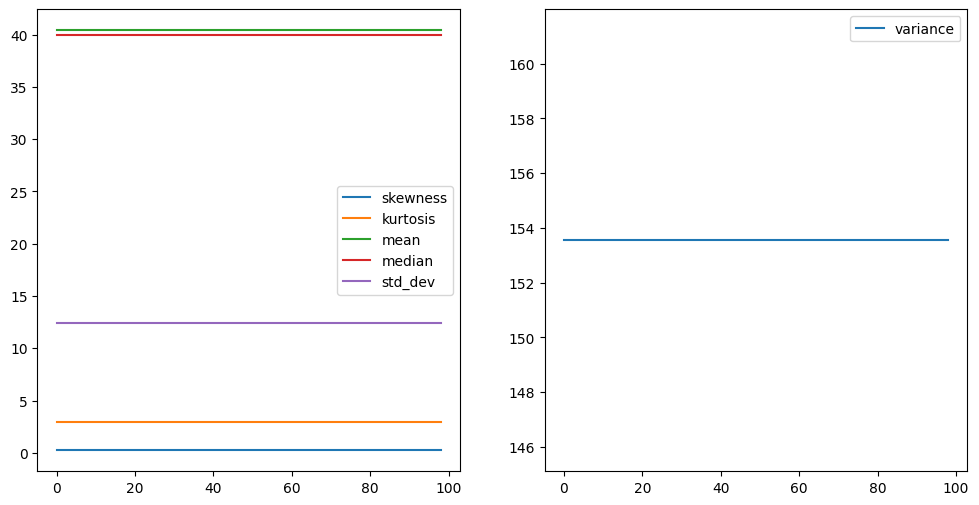

In [ ]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,2)
data_frame["variance"].plot()
plt.legend(["variance"])

plt.subplot(1,2,1)
data_frame["skewness"].plot()
data_frame["kurtosis"].plot()
data_frame["mean"].plot()
data_frame["median"].plot()
data_frame["std_dev"].plot()
plt.legend(["skewness", "kurtosis", "mean", "median", "std_dev"])
plt.show()

capital gain

In [ ]:
max = df['capital-gain'].max()
min = df['capital-gain'].min()
mean = df['capital-gain'].mean()
median = df['capital-gain'].median()
std_dev = df['capital-gain'].std()
var = df['capital-gain'].var()
skew = df['capital-gain'].skew()
kurt = df['capital-gain'].kurt()
print(f'max: {max}')
print(f'min: {min}')
print(f"mean: {mean}")
print(f'median: {median}')
print(f'standard deviation: {std_dev}')
print(f'variance: {var}')
print(f'skewness: {skew}')
print(f'kurtosis: {kurt}')

max: 99999
min: 0
mean: 1079.0676262233324
median: 0.0
standard deviation: 7452.019057655394
variance: 55532588.035659194
skewness: 11.894658996587946
kurtosis: 152.69309629828723


In [ ]:
max_life = int(df["capital-gain"].max())
data_frame = pd.DataFrame({
    "mean":[mean for i in range(max_life)],
    "median":[median for i in range(max_life)],
    "std_dev":[std_dev for i in range(max_life)],
    "variance":[var for i in range(max_life)],
    "skewness":[skew for i in range(max_life)],
    "kurtosis":[kurt for i in range(max_life)]
})

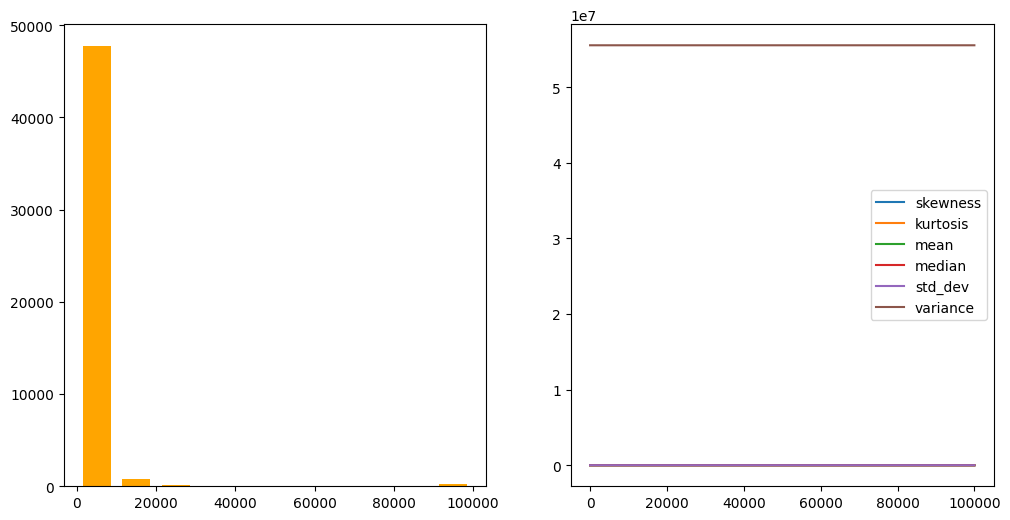

In [ ]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.hist(df["capital-gain"], rwidth = 0.7, color = 'orange')

plt.subplot(1,2,2)
data_frame["skewness"].plot()
data_frame["kurtosis"].plot()
data_frame["mean"].plot()
data_frame["median"].plot()
data_frame["std_dev"].plot()
data_frame["variance"].plot()
plt.legend(["skewness", "kurtosis", "mean", "median", "std_dev", "variance"])
plt.show()

In [ ]:
chunks = [df[i:i+1000] for i in range(0, len(df), 1000)]
skewness = [chunk['capital-gain'].skew() for chunk in chunks]
kurtosis = [chunk['capital-gain'].kurtosis() for chunk in chunks]
print(skewness)
print(kurtosis)

[9.739772655714916, 10.555506994211886, 12.185348273698231, 12.818275655611902, 14.390323645389563, 10.792767627350363, 10.759128268088475, 10.991479502580013, 13.118493571678295, 10.00737418423607, 12.285158674435806, 15.392251672311447, 13.322778010506346, 10.27105709401597, 13.530544175720093, 15.744416181149079, 12.55250431471998, 11.169590646354157, 10.59292663190466, 14.274192750071911, 11.617469654260766, 12.22232937216723, 11.288276133471376, 10.535153379692035, 13.746264454252442, 11.705421139548125, 14.366293123593605, 12.095736127417107, 10.13945405809155, 13.001732800610158, 12.843566096710218, 12.524318861587853, 12.213398220330204, 12.111204302311785, 10.369481685009262, 12.004515532996926, 11.385226086846759, 13.685836544856446, 12.141306924239176, 11.742799168713866, 8.808719471842956, 11.113080951388163, 12.05044991302814, 10.33924865420055, 11.195914537696632, 14.570508544546618, 14.158768976079884, 15.99723191283648, 11.147424987753785]
[99.71554890942063, 116.954198

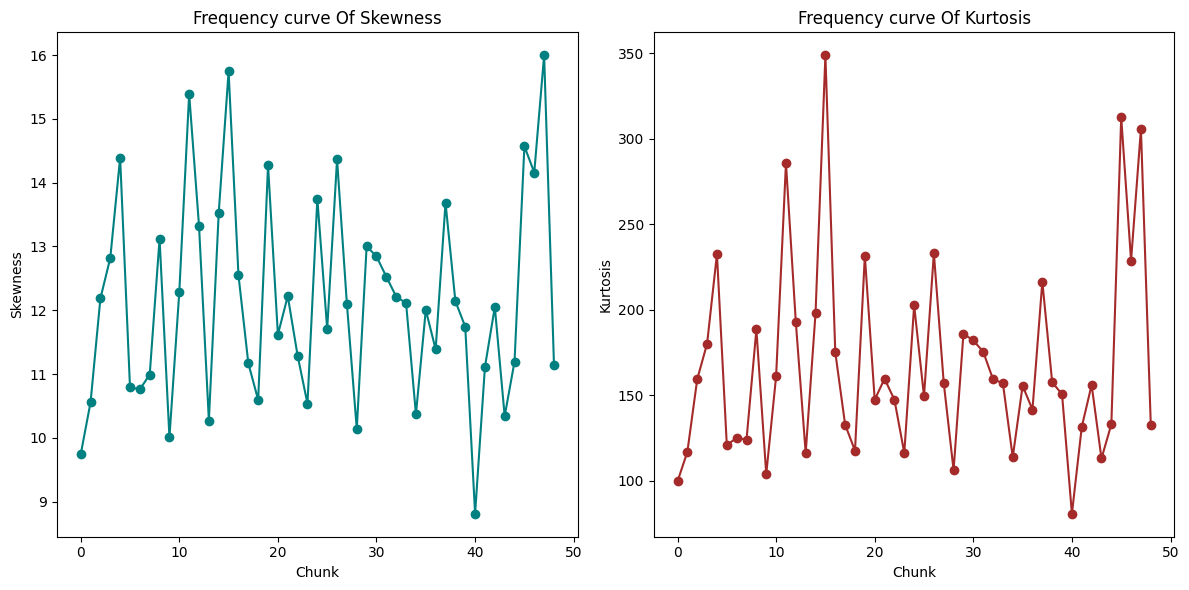

In [ ]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(np.arange(len(skewness)), skewness, color='teal', marker='o', linestyle='-')
plt.title('Frequency curve Of Skewness')
plt.xlabel('Chunk')
plt.ylabel('Skewness')

plt.subplot(1,2,2)
plt.plot(np.arange(len(kurtosis)), kurtosis, color='brown', marker='o', linestyle='-')
plt.title('Frequency curve Of Kurtosis')
plt.xlabel('Chunk')
plt.ylabel('Kurtosis')

plt.tight_layout()
plt.show()

In [ ]:
max = df['capital-loss'].max()
min = df['capital-loss'].min()
mean = df['capital-loss'].mean()
median = df['capital-loss'].median()
std_dev = df['capital-loss'].std()
var = df['capital-loss'].var()
skew = df['capital-loss'].skew()
kurt = df['capital-loss'].kurt()
print(f'max: {max}')
print(f'min: {min}')
print(f"mean: {mean}")
print(f'median: {median}')
print(f'standard deviation: {std_dev}')
print(f'variance: {var}')
print(f'skewness: {skew}')
print(f'kurtosis: {kurt}')

max: 4356
min: 0
mean: 87.50231358257237
median: 0.0
standard deviation: 403.00455212435907
variance: 162412.66903295522
skewness: 4.569808857738484
kurtosis: 20.01434595465143


In [ ]:
max_loss = int(df["capital-loss"].max())
data_frame = pd.DataFrame({
    "mean":[mean for i in range(max_loss)],
    "median":[median for i in range(max_loss)],
    "std_dev":[std_dev for i in range(max_loss)],
    "variance":[var for i in range(max_loss)],
    "skewness":[skew for i in range(max_loss)],
    "kurtosis":[kurt for i in range(max_loss)]
})

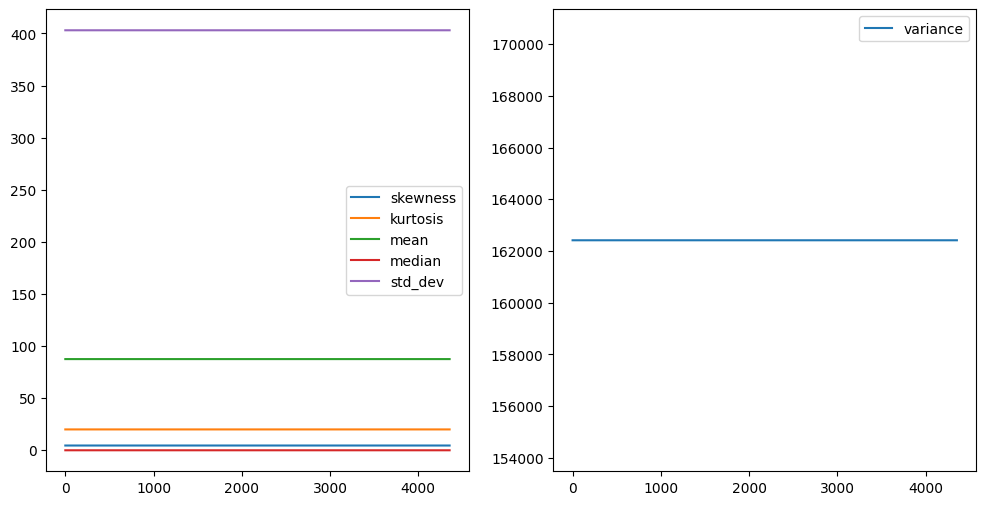

In [ ]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,2)
data_frame["variance"].plot()
plt.legend(["variance"])

plt.subplot(1,2,1)
data_frame["skewness"].plot()
data_frame["kurtosis"].plot()
data_frame["mean"].plot()
data_frame["median"].plot()
data_frame["std_dev"].plot()
plt.legend(["skewness", "kurtosis", "mean", "median", "std_dev"])
plt.show()

In [ ]:
loss_count = df[(df['capital-loss'] >= 3500)]

In [ ]:
max = loss_count['capital-loss'].max()
min = loss_count['capital-loss'].min()
mean = loss_count['capital-loss'].mean()
median = loss_count['capital-loss'].median()
std_dev = loss_count['capital-loss'].std()
var = loss_count['capital-loss'].var()
skew = loss_count['capital-loss'].skew()
kurt = loss_count['capital-loss'].kurt()
print(f'max: {max}')
print(f'min: {min}')
print(f"mean: {mean}")
print(f'median: {median}')
print(f'standard deviation: {std_dev}')
print(f'variance: {var}')
print(f'skewness: {skew}')
print(f'kurtosis: {kurt}')

max: 4356
min: 3683
mean: 3937.6363636363635
median: 3770.0
standard deviation: 277.4895575430804
variance: 77000.45454545454
skewness: 0.9593033062470169
kurtosis: -0.9670816775527098


In [ ]:
max = loss_count['capital-loss'].max()
min = loss_count['capital-loss'].min()
mean = loss_count['capital-loss'].mean()
median = loss_count['capital-loss'].median()
std_dev = loss_count['capital-loss'].std()
var = loss_count['capital-loss'].var()
skew = loss_count['capital-loss'].skew()
kurt = loss_count['capital-loss'].kurt()
print(f'max: {max}')
print(f'min: {min}')
print(f"mean: {mean}")
print(f'median: {median}')
print(f'standard deviation: {std_dev}')
print(f'variance: {var}')
print(f'skewness: {skew}')
print(f'kurtosis: {kurt}')

max: 4356
min: 3683
mean: 3937.6363636363635
median: 3770.0
standard deviation: 277.4895575430804
variance: 77000.45454545454
skewness: 0.9593033062470169
kurtosis: -0.9670816775527098


In [ ]:

max_loss = int(loss_count["capital-loss"].max())
data_frame = pd.DataFrame({
    "mean":[mean for i in range(max_loss)],
    "median":[median for i in range(max_loss)],
    "std_dev":[std_dev for i in range(max_loss)],
    "variance":[var for i in range(max_loss)],
    "skewness":[skew for i in range(max_loss)],
    "kurtosis":[kurt for i in range(max_loss)]
})

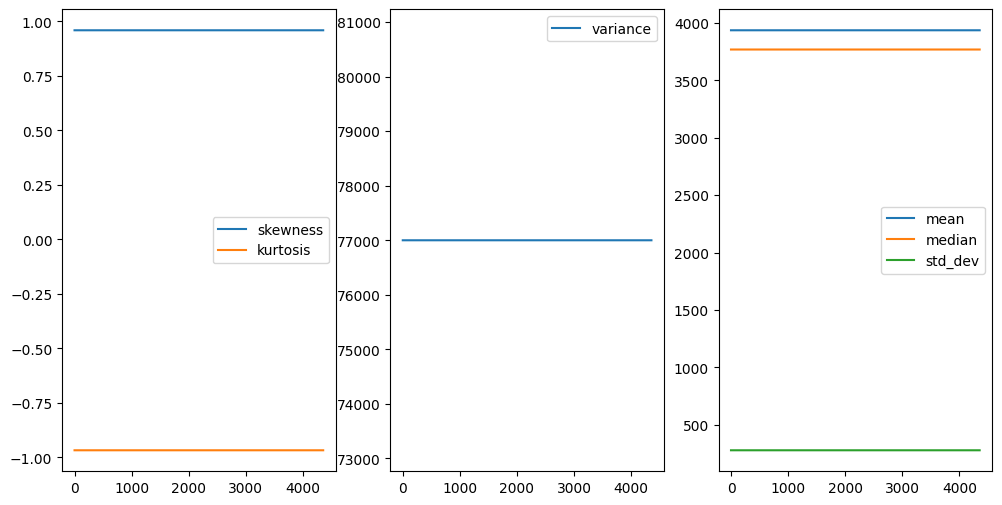

In [ ]:
plt.figure(figsize = (12,6))
plt.subplot(1,3,1)
data_frame["skewness"].plot()
data_frame["kurtosis"].plot()
plt.legend(["skewness", "kurtosis"])

plt.subplot(1,3,2)
data_frame["variance"].plot()
plt.legend(["variance"])

plt.subplot(1,3,3)
data_frame["mean"].plot()
data_frame["median"].plot()
data_frame["std_dev"].plot()
plt.legend(["mean", "median", "std_dev"])
plt.show()

# **4.Model Selection**

In [ ]:
columns_to_keep = ['workclass', 'educational-num', 'marital-status', 'occupation', 'gender', 'native-country', 'income']
Features = df[columns_to_keep]

In [ ]:
X= Features

X = pd.get_dummies(X, columns=['workclass', 'marital-status', 'occupation', 'native-country'])

X = X.drop(columns=['income'])
y = df['income']

x_train, x_test, y_train, y_test = train_test_split(X , y, test_size = 0.3)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [ ]:
print('the shape of the x train data is ' + str(x_train.shape))
print('the shape of the x test data is ' + str(y_test.shape))

the shape of the x train data is (34038, 68)
the shape of the x test data is (14588,)


In [ ]:
Features

,workclass,educational-num,marital-status,occupation,gender,native-country,income
0,Private,7,single,Machine-op-inspct,1,United-States,0
1,Private,9,married,Farming-fishing,1,United-States,0
2,Local-gov,12,married,Protective-serv,1,United-States,1
3,Private,10,married,Machine-op-inspct,1,United-States,1
4,Private,6,single,Other-service,1,United-States,0
...,...,...,...,...,...,...,...
48621,Self-emp-not-inc,4,single,Other-service,0,United-States,0
48622,Private,10,married,Craft-repair,1,United-States,1
48623,Private,13,married,Prof-specialty,1,United-States,0
48624,Private,10,single,Adm-clerical,0,United-States,0


In [ ]:
model = LogisticRegression(penalty='l2')
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [ ]:
print('model score is: ' + str(round(model.score(X_test_scaled, y_test)* 100, 0)) + '%')

model score is: 83.0%


In [ ]:
elastic_net_model = LogisticRegression(penalty='elasticnet', l1_ratio=1.0, solver='saga')
elastic_net_model.fit(X_train_scaled, y_train)

LogisticRegression(l1_ratio=1.0, penalty='elasticnet', solver='saga')

In [ ]:
print('model score is: ' + str(round(elastic_net_model.score(X_test_scaled, y_test)* 100, 0)) + '%')

model score is: 83.0%
